# Intrinsic growth rate

This is the example from section 4.8 of Saltelli et al, 2008, *Global Sensitivity Analysis: A Primer*.

The intrinsic growth rate
$$y(\gamma, k, r, \delta) = \gamma k S_0 - r- \delta,$$
where
$$\begin{aligned}
\gamma &\sim \mathrm{U}(0, 1), \\
r &\sim \mathrm{U}(0, 1), \\
\delta &\sim \mathrm{U}(0, 1), \\
S_0 &= 1000,
\end{aligned}$$
and $k$ will vary across 3 different cases:
$$\begin{aligned}
k &\sim \mathrm{Beta}(2, 7), \\
k &\sim \mathrm{Beta}(0.5, 10), \text{or} \\
k &\sim \mathrm{Beta}(0.2, 15).
\end{aligned}$$

In [1]:
from matplotlib import pyplot
import numpy
import pandas
from scipy import stats
from scipy import fft
import statsmodels.api

import sensitivity_analysis


numpy.random.seed(1)


def model(𝛾, k, r, 𝛿, S_0=1000):
    '''The intrinsic growth rate.'''
    y = 𝛾 * k * S_0 - r - 𝛿
    try:
        return y.rename('y')
    except AttributeError:
        return y


# Different cases of the a & b values for k ~ Beta(a, b).
k_parameters = ((2, 7), 
                (0.5, 10), 
                (0.2, 15))

parameter_sets = {
    f'Case {i + 1}': dict(𝛾=stats.uniform(0, 1),
                          k=stats.beta(a, b),
                          r=stats.uniform(0, 1),
                          𝛿=stats.uniform(0, 1))
    for (i, (a, b)) in enumerate(k_parameters)}

n_samples = 1280

### Figure 4.2

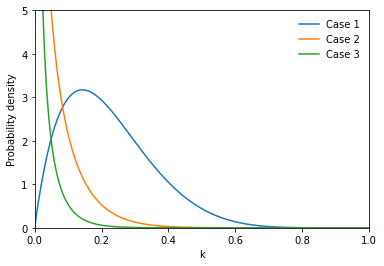

In [2]:
x = numpy.linspace(0, 1, 301)
p = 'k'
for (case, parameters) in parameter_sets.items():
    pyplot.plot(x, parameters[p].pdf(x), label=case)
pyplot.autoscale(tight=True)
pyplot.xlabel(p)
pyplot.ylabel('Probability density')
pyplot.ylim(0, 5)
_ = pyplot.legend()

### Figure 4.1

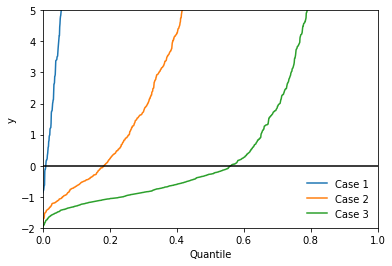

In [3]:
q = numpy.linspace(0, 1, n_samples)
for (case, parameters) in parameter_sets.items():
    X = sensitivity_analysis.samples_unstructured(parameters, n_samples)
    y = model(**X)
    pyplot.plot(q, numpy.sort(y), label=case)
pyplot.axhline(0, color='black')
pyplot.xlabel('Quantile')
pyplot.ylabel(y.name)
pyplot.autoscale(tight=True)
pyplot.ylim(-2, 5)
_ = pyplot.legend()

## Sobol' indexes

### Tables 4.1, 4.2, & 4.3

In [4]:
def bold_sum(s):
    '''Made the 'Sum' row bold.'''
    is_sum = (s.index == 'Sum')
    return ['font-weight: bold' if v else '' for v in is_sum]


def display_Sobol_indexes(S, S_PE, S_T, S_T_PE, alpha=0.5):
    '''Display the Sobol' indexes S and S_T in a nice table.'''
    table = pandas.concat((S, S_PE, S_T, S_T_PE), axis='columns')
    CI_percent = 100 * (1 - alpha)
    columns = pandas.MultiIndex.from_product(
        (('First-order index ($S$)', 'Total-order index ($S_T$)'),
         ('Estimate', f'{CI_percent:g}% probable error')))
    table.set_axis(columns, axis='columns', inplace=True)
    table.loc['Sum'] = table.sum()
    # Don't show the sum of the probable errors.
    estimates = (columns.get_level_values(1) == 'Estimate')
    table.loc['Sum', ~estimates] = ''
    display(table.style.apply(bold_sum))


alpha = 0.1
for (case, parameters) in parameter_sets.items():
    (S, S_PE, S_T, S_T_PE) = sensitivity_analysis.Sobol_indexes(
        model, parameters, n_samples, alpha=alpha)
    print(case)
    display_Sobol_indexes(S, S_PE, S_T, S_T_PE, alpha=alpha)

Case 1


Case 2


Case 3


### Random Balance Designs

A more-efficient method for computing Sobol's first-order index ($S$).

#### Table 4.4

In [5]:
def display_with_sums(table):
    '''Add column sums and display.'''
    table = table.copy()
    table.loc['Sum'] = table.sum()
    return table.style.apply(bold_sum)


S_RBD = pandas.DataFrame(columns=parameter_sets.keys())
for (case, parameters) in parameter_sets.items():
    S_RBD[case] = sensitivity_analysis.S_RBD(
        model, parameters, n_samples)

display_with_sums(S_RBD)

,Case 1,Case 2,Case 3
γ,0.41859,0.127531,0.0442315
k,0.508357,0.61135,0.603251
r,0.0116699,0.0124187,0.0166396
δ,0.00879059,0.00664808,0.00830176
Sum,0.947408,0.757947,0.672424


#### Plots of $\mathrm{E}_{X_{\sim i}}(y | X_i)$

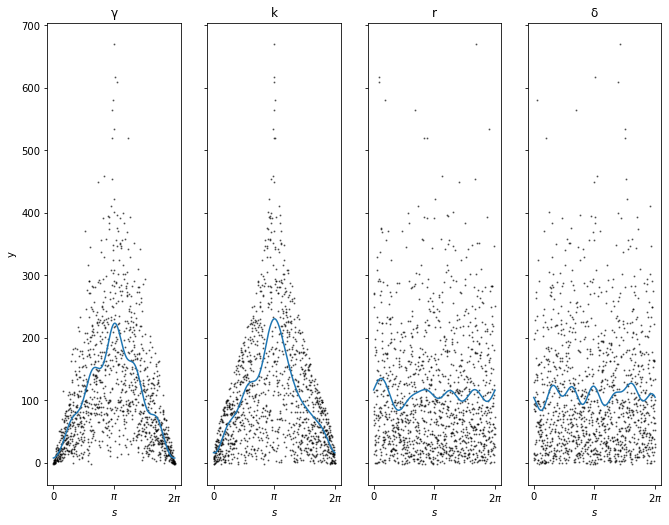

In [6]:
parameters = parameter_sets['Case 1']
n_params = len(parameters)

n_freqs = 6

s_0 = numpy.linspace(0, 2 * numpy.pi, n_samples)
index = parameters.keys()
s = pandas.DataFrame({i: numpy.random.permutation(s_0)
                      for i in index})
q = numpy.arccos(numpy.cos(s)) / numpy.pi
X = pandas.DataFrame({i: parameters[i].ppf(q[i])
                      for i in index})
y = model(**X)
(fig, axes) = pyplot.subplots(1, len(index), sharey=True, figsize=(11, 8.5))
for (i, ax) in zip(index, axes):
    ax.scatter(s[i], y,
               s=1, color='black', alpha=0.5)
    order = numpy.argsort(s[i])
    y_reordered = y[order]
    y_hat = numpy.fft.rfft(y_reordered)
    y_hat[n_freqs + 1 :] = 0
    EyXnoti = numpy.fft.irfft(y_hat, n_samples)
    ax.plot(s_0, EyXnoti)
    ax.set_xlabel(f'$s$')
    ax.set_xticks([0, numpy.pi, 2 * numpy.pi])
    ax.set_xticklabels([0, '$\pi$', '$2 \pi$'])
    ax.set_title(i)
    if ax.is_first_col():
        ax.set_ylabel(y.name)
pyplot.show()

#### Alternatives to Fourier series for $\mathrm{E}_{X_{\sim i}}(y|X_i)$

What if we try Fourier cosine series, 5th-order polynomials, or LOWESS instead?

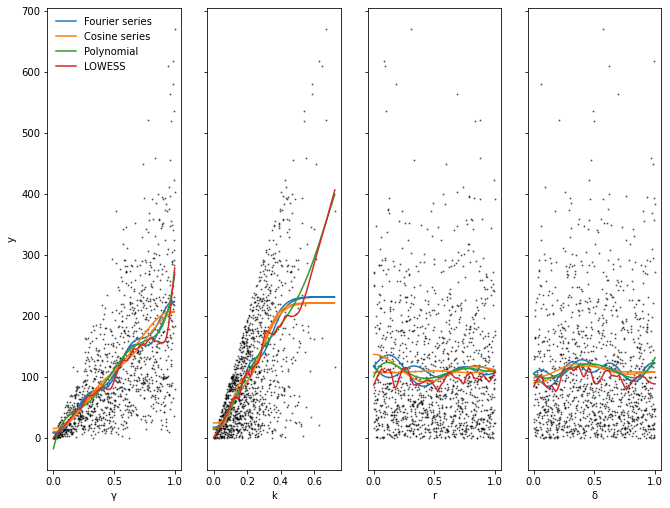

,Fourier,Cosine,Polynomial,LOWESS
γ,0.416013,0.407852,0.422757,0.365949
k,0.392121,0.387674,0.407605,0.389973
r,0.0130577,0.00876766,0.00568292,0.00806888
δ,0.0124621,0.00565373,0.00771767,0.0116193
Sum,0.833654,0.809947,0.843763,0.775611


In [7]:
S = pandas.Series(index=index)
S_cos = pandas.Series(index=index)
S_lowess = pandas.Series(index=index)
S_poly = pandas.Series(index=index)
(fig, axes) = pyplot.subplots(1, len(index), sharey=True, figsize=(11, 8.5))
for (i, ax) in zip(index, axes):
    ax.scatter(X[i], y,
               s=1, color='black', alpha=0.5)
    order = numpy.argsort(s[i])
    y_reordered = y[order]
    y_hat = numpy.fft.rfft(y_reordered)
    # Fourier series.
    spectrum_y = 2 * numpy.abs(y_hat / n_samples) ** 2
    spectrum_EyXnoti = spectrum_y[: n_freqs + 1]
    var_EyXnoti = spectrum_EyXnoti[1:].sum()
    var_y = spectrum_y[1:].sum()
    S[i] = var_EyXnoti / var_y
    y_hat[n_freqs + 1 : ] = 0
    EyXnoti = numpy.fft.irfft(y_hat, n_samples)
    ax.plot(X[i].iloc[order], EyXnoti,
            label='Fourier series')
    # Cosine series.
    # y_hat = fft.dct(y[order], norm='ortho')
    # Avoid warning.
    y_hat = fft.dct(numpy.asarray(y[order]), norm='ortho')
    spectrum_y = y_hat ** 2
    spectrum_EyXnoti = spectrum_y[: n_freqs + 1]
    var_EyXnoti = spectrum_EyXnoti[1:].sum() / n_samples
    var_y = spectrum_y[1:].sum() / n_samples
    S_cos[i] = var_EyXnoti / var_y
    y_hat[n_freqs + 1 : ] = 0
    EyXnoti = fft.idct(y_hat, norm='ortho')
    ax.plot(X[i].iloc[order], EyXnoti,
            label='Cosine series')    
    # Polynomial.
    order = numpy.argsort(X[i])
    p = numpy.polyfit(X[i].iloc[order], y[order],
                      deg=5)
    EyXnoti = numpy.polyval(p, X[i].iloc[order])
    S_poly[i] = numpy.var(EyXnoti, ddof=1) / numpy.var(y, ddof=1)
    ax.plot(X[i].iloc[order], EyXnoti,
            label='Polynomial')
    # LOWESS.
    EyXnoti = statsmodels.api.nonparametric.lowess(
        y[order], X[i].iloc[order],
        frac=0.1, it=1,
        is_sorted=True, return_sorted=False)
    S_lowess[i] = numpy.var(EyXnoti, ddof=1) / numpy.var(y, ddof=1)
    ax.plot(X[i].iloc[order], EyXnoti,
            label='LOWESS')
    ax.set_xlabel(i)
    if ax.is_first_col():
        ax.set_ylabel(y.name)
axes[0].legend()
pyplot.show()

table = pandas.DataFrame({'Fourier': S,
                          'Cosine': S_cos,
                          'Polynomial': S_poly,
                          'LOWESS': S_lowess})
display_with_sums(table)

##### Problem

Can we figure out how to compute the total-order indexes
$$S_{\mathrm{T}i}
= \frac{\mathrm{E}_{X_{\sim i}}\big(\mathrm{V}_{X_i}(y|X_{\sim i})\big)}{\mathrm{V}(y)}
= 1 - \frac{\mathrm{V}_{X_{\sim i}}\big(\mathrm{E}_{X_i}(y|X_{\sim i})\big)}{\mathrm{V}(y)}
$$
using the $n$-dimensional FFT or other interpolant?

We should probably first try the second-order indexes
$$S_{ij} = \frac{\mathrm{V}_{X_i, X_j}\big(\mathrm{E}_{X_{\sim i, j}}(y|X_i, X_j)\big)}{\mathrm{V}(y)}.$$

### Random Balance Designs using the DCT

A cleaner method for computing Random Balance Designs using the DCT instead of the FFT.

#### Table 4.4 again

In [8]:
S_RBD_DCT = pandas.DataFrame(columns=parameter_sets.keys())
for (case, parameters) in parameter_sets.items():
    S_RBD_DCT[case] = sensitivity_analysis.S_RBD_DCT(
        model, parameters, n_samples)

display_with_sums(S_RBD_DCT)

,Case 1,Case 2,Case 3
γ,0.415138,0.105359,0.0454969
k,0.443979,0.529467,0.57561
r,0.00203202,0.00134763,0.00122993
δ,0.00566121,0.00504657,0.00533619
Sum,0.86681,0.64122,0.627673


#### Plots of $\mathrm{E}_{X_{\sim i}}(y | X_i)$

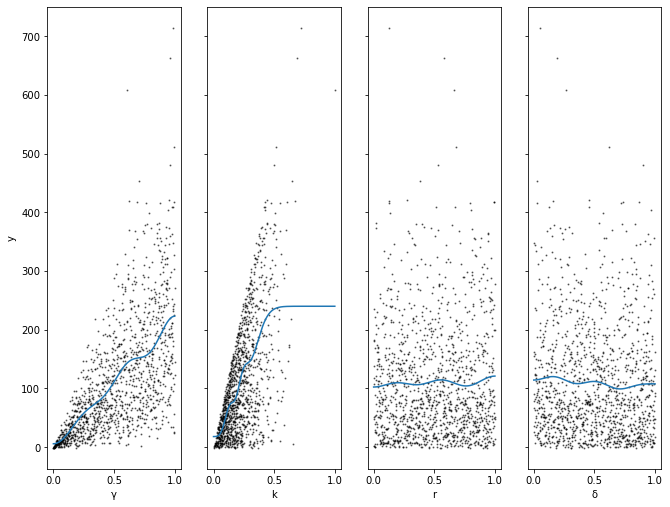

In [9]:
parameters = parameter_sets['Case 1']
n_params = len(parameters)

n_freqs = 6

q_0 = numpy.linspace(0, 1, n_samples)
index = parameters.keys()
q = pandas.DataFrame({i: numpy.random.permutation(q_0)
                      for i in index})
X = pandas.DataFrame({i: parameters[i].ppf(q[i])
                      for i in index})
y = model(**X)
(fig, axes) = pyplot.subplots(1, len(index), sharey=True, figsize=(11, 8.5))
for (i, ax) in zip(index, axes):
    ax.scatter(X[i], y,
               s=1, color='black', alpha=0.5)
    order = numpy.argsort(q[i])
    # y_hat = fft.dct(y[order], norm='ortho')
    # Avoid warning.
    y_hat = fft.dct(numpy.asarray(y[order]), norm='ortho')
    y_hat[n_freqs + 1 :] = 0
    EyXnoti = fft.idct(y_hat, norm='ortho')
    ax.plot(X[i].iloc[order], EyXnoti)
    ax.set_xlabel(i)
    if ax.is_first_col():
        ax.set_ylabel(y.name)
pyplot.show()

## Derivatives

In [10]:
S2_sigma = pandas.DataFrame(columns=parameter_sets.keys())
for (case, parameters) in parameter_sets.items():
    S = sensitivity_analysis.sensitivity(
        model, parameters, n_samples)
    S2_sigma[case] = S ** 2

display_with_sums(S2_sigma)

,Case 1,Case 2,Case 3
γ,0.375216,0.115633,0.0682925
k,0.393504,0.599315,0.963098
r,7.60014e-06,5.10698e-05,0.000392576
δ,7.59937e-06,5.10711e-05,0.000392548
Sum,0.768736,0.71505,1.03218


## Linear regression

In [11]:
beta2_sigma = pandas.DataFrame(columns=parameter_sets.keys())
for (case, parameters) in parameter_sets.items():
    beta = sensitivity_analysis.linreg_coefficients(
        model, parameters, n_samples)
    beta2_sigma[case] = beta ** 2

display_with_sums(beta2_sigma)

,Case 1,Case 2,Case 3
γ,0.455059,0.123249,0.0488753
k,0.424149,0.66357,0.747933
r,0.000243822,0.000187793,0.00051983
δ,0.000898368,7.21593e-06,1.24481e-05
Sum,0.88035,0.787014,0.797341


## Derivative-based global sensitivity measure

From Lamboni et al, 2013, with the measure here also weighted by the variances.

In [12]:
DGSM_sigma = pandas.DataFrame(columns=parameter_sets.keys())
for (case, parameters) in parameter_sets.items():
    DGSM_sigma[case] = sensitivity_analysis.DGSM(
        model, parameters, n_samples)

display_with_sums(DGSM_sigma)

,Case 1,Case 2,Case 3
γ,0.615241,0.292365,0.263245
k,0.638123,0.741323,0.86561
r,9.22854e-06,4.727e-05,0.000270625
δ,9.22788e-06,4.72634e-05,0.000270634
Sum,1.25338,1.03378,1.1294


## Partial rank correlation coefficients

In [13]:
PRCC = pandas.DataFrame(columns=parameter_sets.keys())
for (case, parameters) in parameter_sets.items():
    PRCC[case] = sensitivity_analysis.PRCC(
        model, parameters, n_samples)

display(PRCC)

,Case 1,Case 2,Case 3
γ,0.921921,0.824148,0.479040
k,0.896313,0.952652,0.909082
r,0.001203,-0.121521,-0.515328
δ,0.007568,-0.168549,-0.502945
